In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
)
from njit_funcs import *
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

In [36]:
plt.rcParams["figure.figsize"] = [29, 18]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [37]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "CRVUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2021-05-01"
        self.end_date = "2022-01-30"
        self.starting_balance = 100.0
        self.starting_configs = ""
        self.base_dir = "backtests"


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
data = await dl.get_sampled_ticks()
timestamps = data[:, 0]
qtys = data[:, 1]
prices = data[:, 2]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
2022-01-30T11:32:54  Loading cached tick data from backtests\binance\CRVUSDT\caches\2021-05-01_2022-01-30_ticks_cache.npy 
millis to load 23673599 ticks 646ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

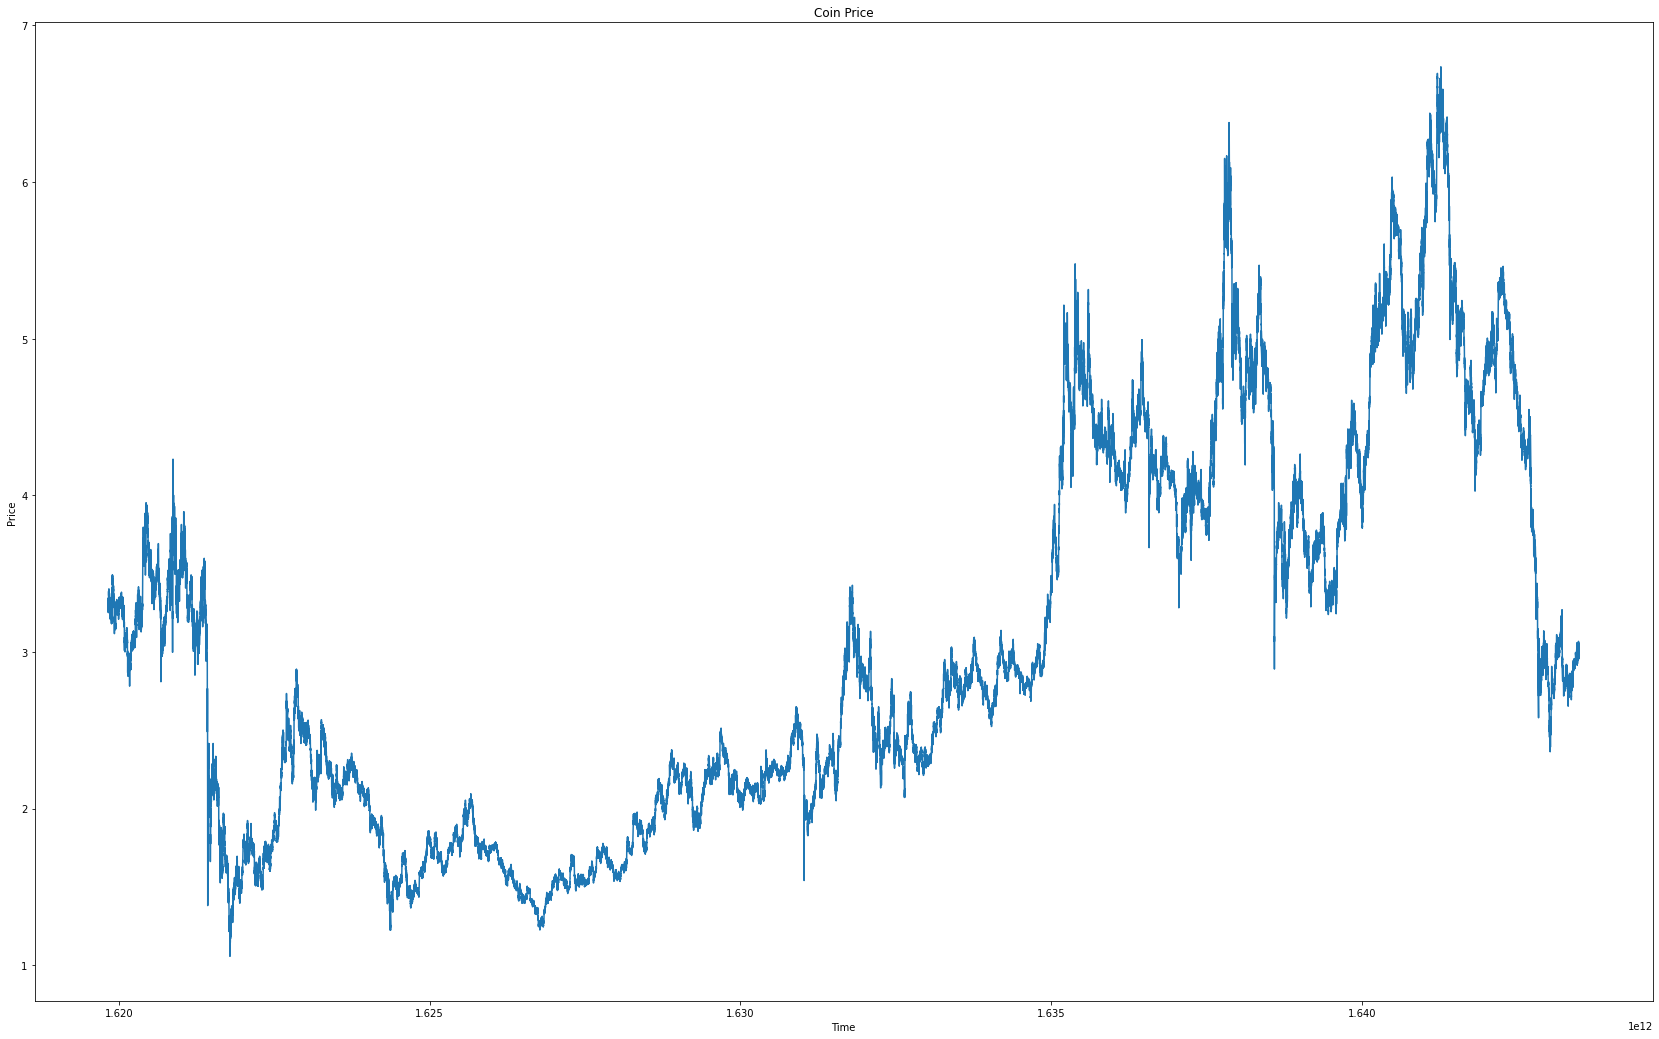

In [38]:
df = pd.DataFrame({"timestamp": timestamps, "qty": qtys, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [39]:
# choose a slice on which to test
wsize_days = 365 ## test for wsize_days number of days , here it is 365 days :P
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]

In [40]:
hand_tuned = {
    "config_name": "v5.3_test",
    "logging_level": 0,
    "long": {
        "auto_unstuck_ema_dist": -0.0022360150262206967,
        "auto_unstuck_wallet_exposure_threshold": 0.12380908880800262,
        "ema_span_max": 6382.894847577279,
        "ema_span_min": 9456.979757572499,
        "enabled": True,
        "eprice_exp_base": 1.162367765707554,
        "eprice_pprice_diff": 0.008041756256016455,
        "grid_span": 0.5616694811892784,
        "initial_eprice_ema_dist": 0.05,
        "initial_qty_pct": 0.024960354694655303,
        "markup_range": 0.014970605317685695,
        "max_n_entry_orders": 13,
        "min_markup": 0.04,
        "n_close_orders": 6,
        "secondary_allocation": 0,
        "secondary_pprice_diff": 0.05,
        "wallet_exposure_limit": 0.05
    },  # positive is further away; negative is closer
    "short": {
        "auto_unstuck_ema_dist": 0.041256404251012624,
        "auto_unstuck_wallet_exposure_threshold": 0.1573138511601284,
        "ema_span_max": 757.4618644339793,
        "ema_span_min": 1844.531106796071,
        "enabled": True,
        "eprice_exp_base": 1.7949217756175226,
        "eprice_pprice_diff": 0.007569448385435332,
        "grid_span": 0.25895414317543664,
        "initial_eprice_ema_dist": 0.0481584901038529,
        "initial_qty_pct": 0.029980799241807056,
        "markup_range": 0.02337346490889047,
        "max_n_entry_orders": 14,
        "min_markup": 0.013808705127077641,
        "n_close_orders": 12,
        "secondary_allocation": 0,
        "secondary_pprice_diff": 0.05,
        "wallet_exposure_limit": 0.05
    },
}

# hand_tuned = load_live_config('configs/live/allround.json')
# hand_tuned['short']['enabled'] = True
config["starting_balance"] = Args().starting_balance
config["latency_simulation_ms"] = 1000
config_to_test = {**config, **numpyize(hand_tuned)}
dump_live_config(config_to_test, make_get_filepath(f"tmp/hand_tuned.json"))
hand_tuned

{'config_name': 'v5.3_test',
 'logging_level': 0,
 'long': {'auto_unstuck_ema_dist': -0.0022360150262206967,
  'auto_unstuck_wallet_exposure_threshold': 0.12380908880800262,
  'ema_span_max': 6382.894847577279,
  'ema_span_min': 9456.979757572499,
  'enabled': True,
  'eprice_exp_base': 1.162367765707554,
  'eprice_pprice_diff': 0.008041756256016455,
  'grid_span': 0.5616694811892784,
  'initial_eprice_ema_dist': 0.05,
  'initial_qty_pct': 0.024960354694655303,
  'markup_range': 0.014970605317685695,
  'max_n_entry_orders': 13,
  'min_markup': 0.04,
  'n_close_orders': 6,
  'secondary_allocation': 0,
  'secondary_pprice_diff': 0.05,
  'wallet_exposure_limit': 0.05},
 'short': {'auto_unstuck_ema_dist': 0.041256404251012624,
  'auto_unstuck_wallet_exposure_threshold': 0.1573138511601284,
  'ema_span_max': 757.4618644339793,
  'ema_span_min': 1844.531106796071,
  'enabled': True,
  'eprice_exp_base': 1.7949217756175226,
  'eprice_pprice_diff': 0.007569448385435332,
  'grid_span': 0.258954

In [41]:
sts = time()
fills, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
fdf, sdf, analysis = analyze_fills(fills, stats, config_to_test)
pprint.pprint(analysis)
fdf

seconds elapsed 32.7190
{'DGstd_long': 0.0028976605266015434,
 'DGstd_short': 0.010229928837807063,
 'adg_DGstd_ratio_long': 0.06757371978414135,
 'adg_DGstd_ratio_short': -0.003731756412519151,
 'adg_long': 0.00019580570045414018,
 'adg_per_exposure_long': 0.003916114009082803,
 'adg_per_exposure_short': -0.0007635120508020218,
 'adg_short': -3.817560254010109e-05,
 'average_daily_gain': 0.0004179419636674009,
 'avg_fills_per_day': 0.8787267498678599,
 'avg_fills_per_day_long': 0.3627084882433294,
 'avg_fills_per_day_short': 0.5160182616245306,
 'biggest_psize': 3.9,
 'biggest_psize_long': 2.3,
 'biggest_psize_quote': 5.6873000000000005,
 'biggest_psize_quote_long': 5.665100000000001,
 'biggest_psize_quote_short': 5.6873000000000005,
 'biggest_psize_short': 3.9,
 'closest_bkr': 1.0,
 'eqbal_ratio_mean': 0.9381276851917849,
 'eqbal_ratio_min': 0.8145035114845661,
 'exchange': 'binance',
 'fee_sum': -0.19741142,
 'fee_sum_long': -0.08248964000000002,
 'fee_sum_short': -0.11492178,
 'fin

,trade_id,timestamp,pnl,fee_paid,balance,equity,qty,price,psize,pprice,type,wallet_exposure
0,567421,1620394622000.0,0.0000,-0.00103572,99.99896428,99.99896428,-1.4,3.699,-1.4,3.6990,short_ientry,0.0517865364
1,568621,1620395822000.0,0.0728,-0.00102116,100.07074312,100.07074312,1.4,3.647,0.0,3.6990,short_nclose,0.0000000000
2,568625,1620395826000.0,0.0000,-0.00101864,100.06972448,100.06972448,-1.4,3.638,-1.4,3.6380,short_ientry,0.0508965127
3,569256,1620396457000.0,0.0714,-0.00100436,100.14012012,100.14012012,1.4,3.587,0.0,3.6380,short_nclose,0.0000000000
4,569257,1620396458000.0,0.0000,-0.00100492,100.13911520,100.13911520,-1.4,3.589,-1.4,3.5890,short_ientry,0.0501761973
...,...,...,...,...,...,...,...,...,...,...,...,...
230,20959364,1640786565000.0,0.2167,-0.00112398,111.61080868,97.36130868,-1.1,5.109,0.0,4.9120,long_nclose,0.0000000000
231,20979400,1640806601000.0,0.0000,-0.00107316,111.60973552,98.28123552,1.1,4.878,1.1,4.8780,long_ientry,0.0480764512
232,21036981,1640864182000.0,0.2156,-0.00111628,111.82421924,97.70731924,-1.1,5.074,0.0,4.8780,long_nclose,0.0000000000
233,21584721,1641411922000.0,0.0000,-0.00101772,111.82320152,95.48090152,0.9,5.654,0.9,5.6540,long_ientry,0.0455057620


In [42]:
sdf

,timestamp,balance,equity,bkr_price,long_psize,long_pprice,short_psize,short_pprice,price,closest_bkr,balance_long,balance_short,equity_long,equity_short,long_wallet_exposure,short_wallet_exposure
0,1620394620000.0,100.00000000,100.00000000,0.0000000000,0.0,0.0000,0.0,0.0000000000,3.700,1.0,100.00000000,100.00000000,100.00000000,100.00000000,0.000000000,0.0000000000
1,1620394680000.0,99.99896428,99.98636428,39.4129158143,0.0,0.0000,-1.4,3.6990000000,3.708,1.0,100.00000000,99.99896428,100.00000000,99.98636428,0.000000000,0.0517865364
2,1620394740000.0,99.99896428,100.00036428,39.4129158143,0.0,0.0000,-1.4,3.6990000000,3.698,1.0,100.00000000,99.99896428,100.00000000,100.00036428,0.000000000,0.0517865364
3,1620394800000.0,99.99896428,100.02276428,39.4129158143,0.0,0.0000,-1.4,3.6990000000,3.682,1.0,100.00000000,99.99896428,100.00000000,100.02276428,0.000000000,0.0517865364
4,1620394860000.0,99.99896428,100.01576428,39.4129158143,0.0,0.0000,-1.4,3.6990000000,3.687,1.0,100.00000000,99.99896428,100.00000000,100.01576428,0.000000000,0.0517865364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377256,1643500523000.0,111.82308858,103.20058858,38.5714098552,1.0,5.6533,-3.9,1.4582820513,2.985,1.0,107.91801036,103.90507822,105.24971036,97.95087822,0.050555749,0.0508598007
377257,1643500593000.0,111.82308858,103.20928858,38.5714098552,1.0,5.6533,-3.9,1.4582820513,2.982,1.0,107.91801036,103.90507822,105.24671036,97.96257822,0.050555749,0.0508598007
377258,1643500659000.0,111.82308858,103.20348858,38.5714098552,1.0,5.6533,-3.9,1.4582820513,2.984,1.0,107.91801036,103.90507822,105.24871036,97.95477822,0.050555749,0.0508598007
377259,1643500719000.0,111.82308858,103.18898858,38.5714098552,1.0,5.6533,-3.9,1.4582820513,2.989,1.0,107.91801036,103.90507822,105.25371036,97.93527822,0.050555749,0.0508598007


<AxesSubplot:title={'center':'Balance and equity'}, xlabel='Time', ylabel='Balance'>

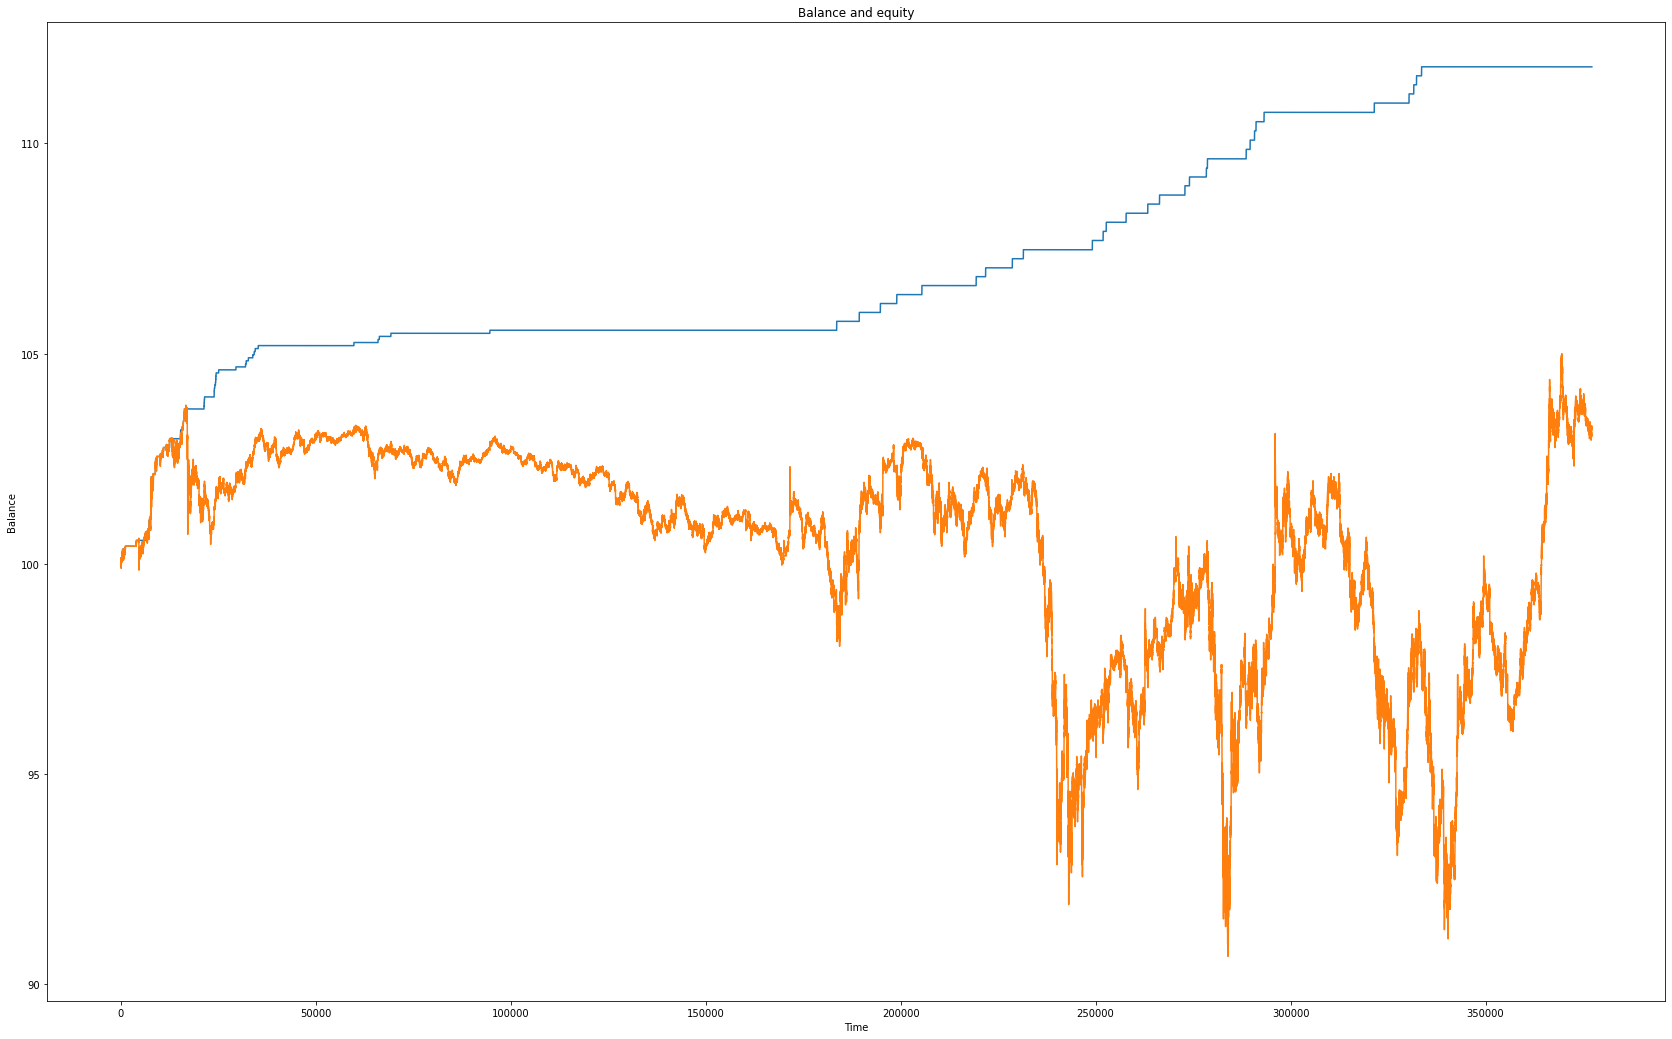

In [43]:
sdf.balance.plot()
sdf.equity.plot(title="Balance and equity", xlabel="Time", ylabel="Balance")

<module 'matplotlib.pyplot' from 'C:\\Users\\skhan\\anaconda3\\envs\\passivbot\\lib\\site-packages\\matplotlib\\pyplot.py'>

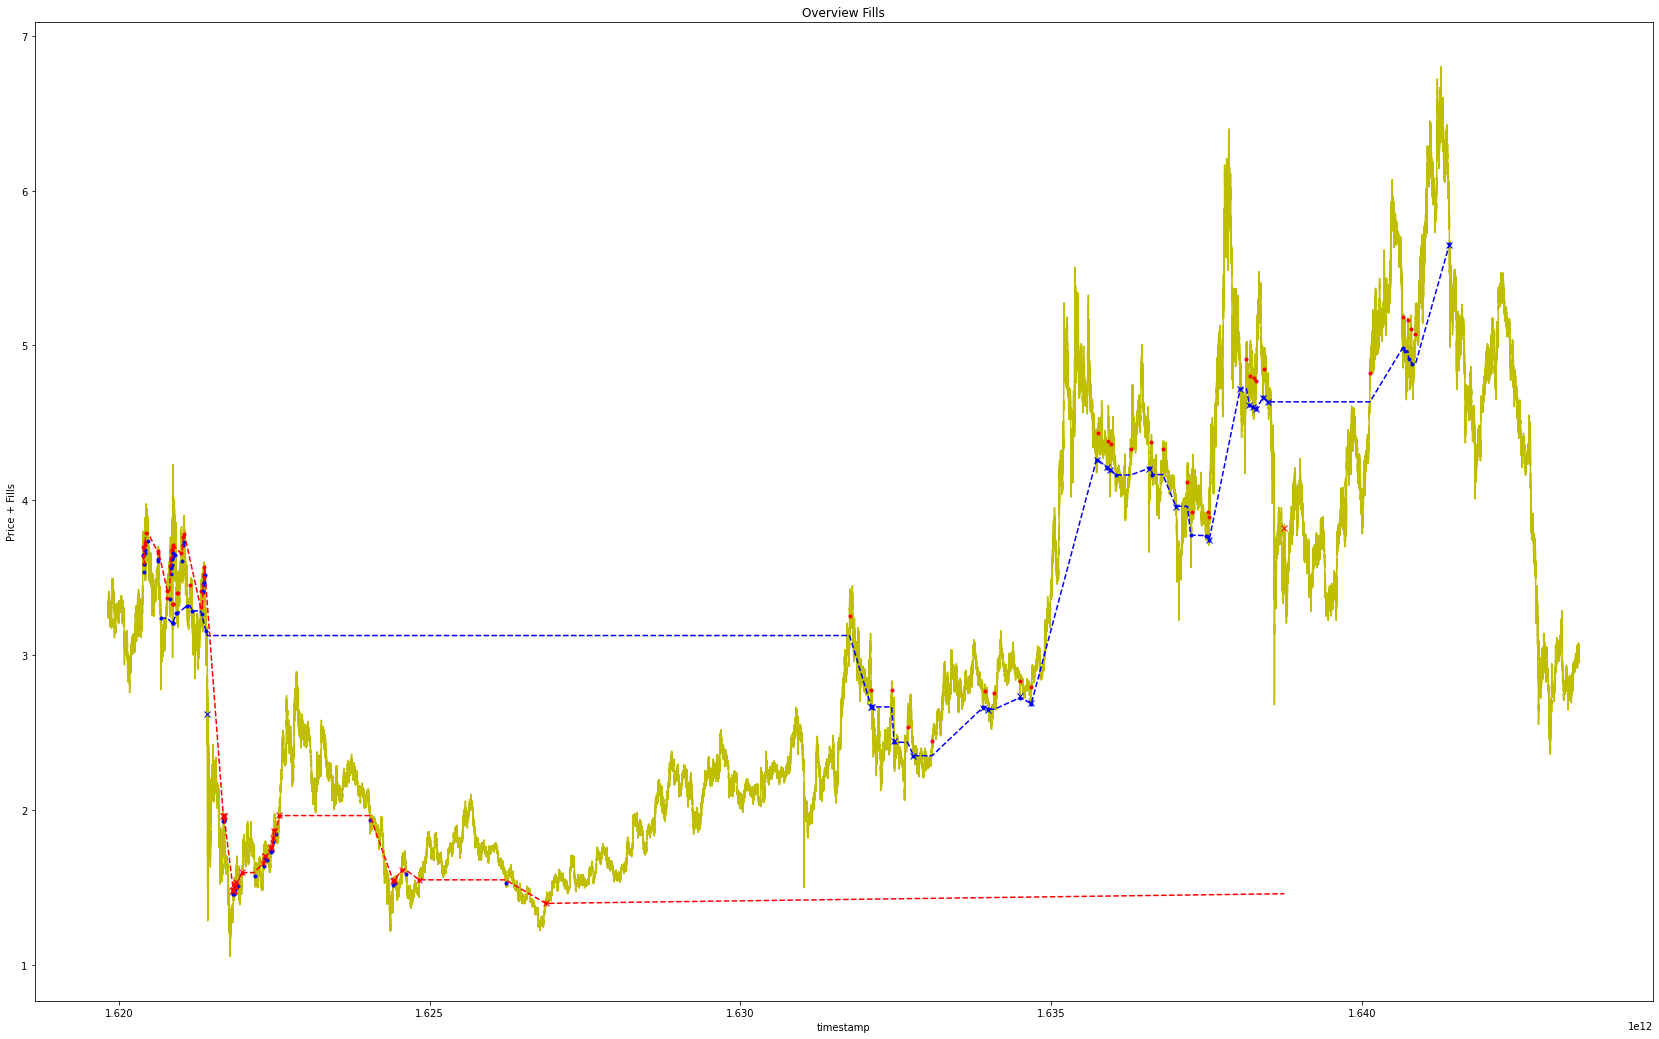

In [44]:
plot_fills(df, fdf, plot_whole_df=True, title="Overview Fills")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Short Position size'>

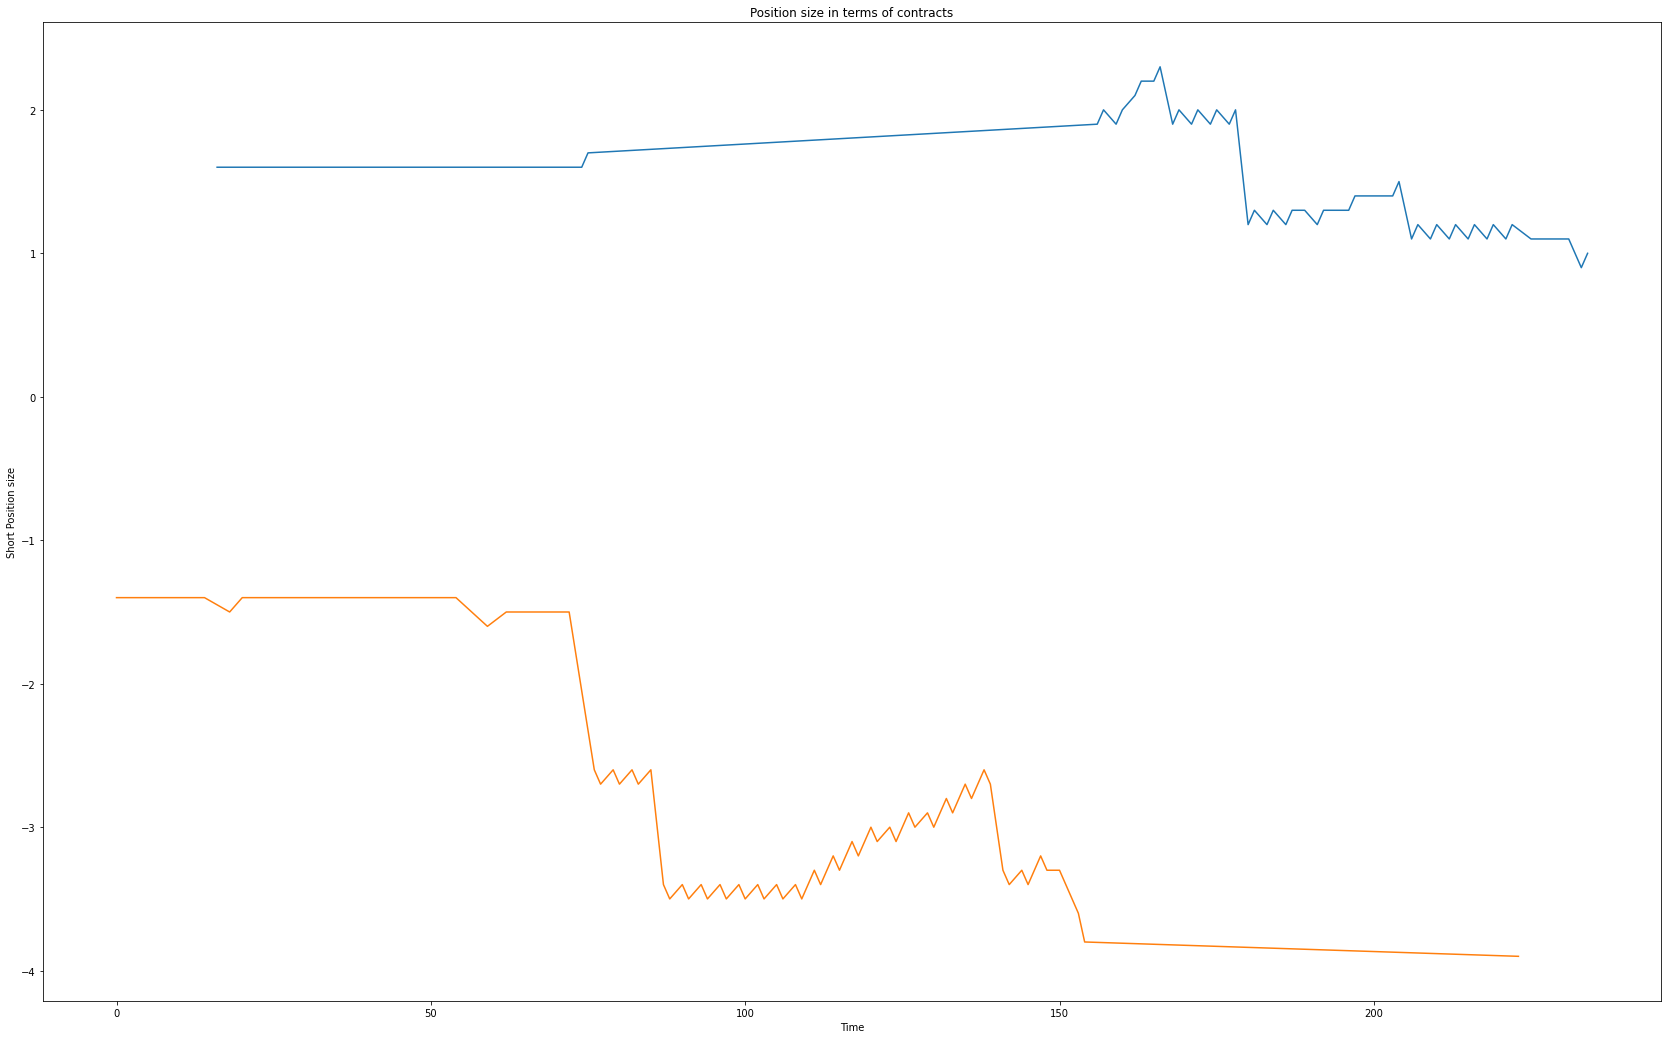

In [45]:
fdf[fdf.psize > 0.0].psize.plot(
    title="Position size in terms of contracts",
    xlabel="Time",
    ylabel="Long Position size",
)
fdf[fdf.psize < 0.0].psize.plot(
    title="Position size in terms of contracts",
    xlabel="Time",
    ylabel="Short Position size",
)

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

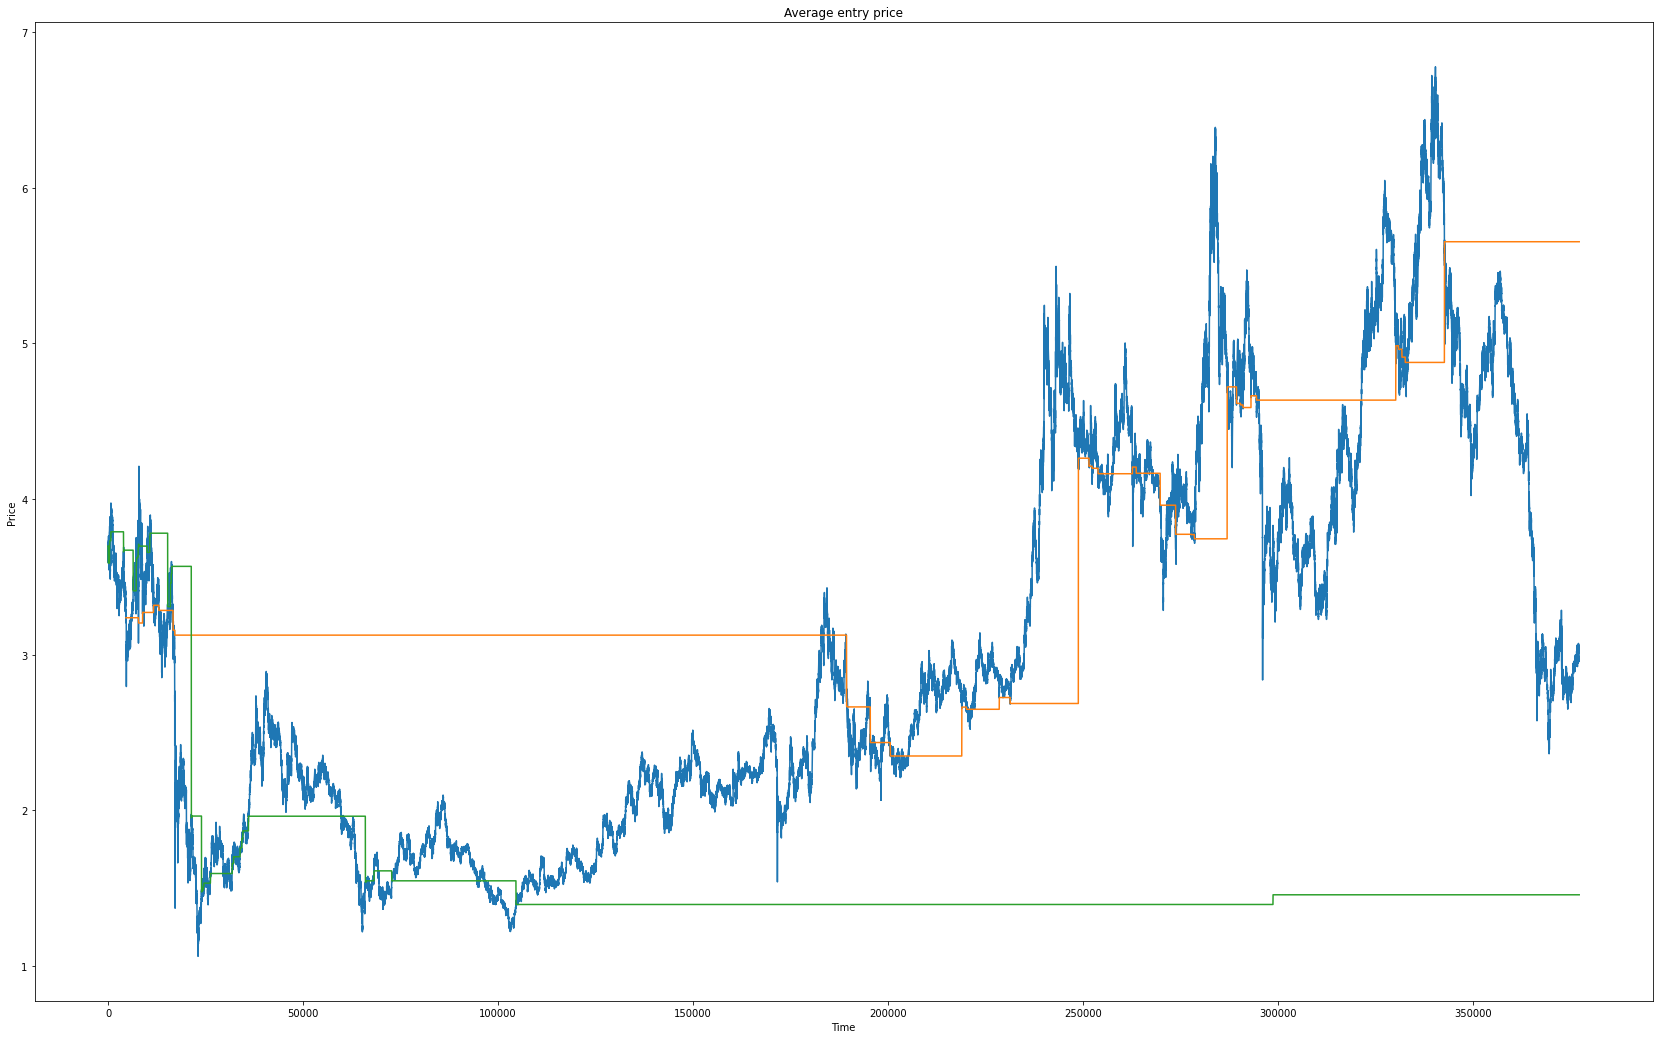

In [46]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf.long_pprice.replace(0.0, np.nan).plot()
sdf.short_pprice.replace(0.0, np.nan).plot()

Mean price action distance long 0.402669


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

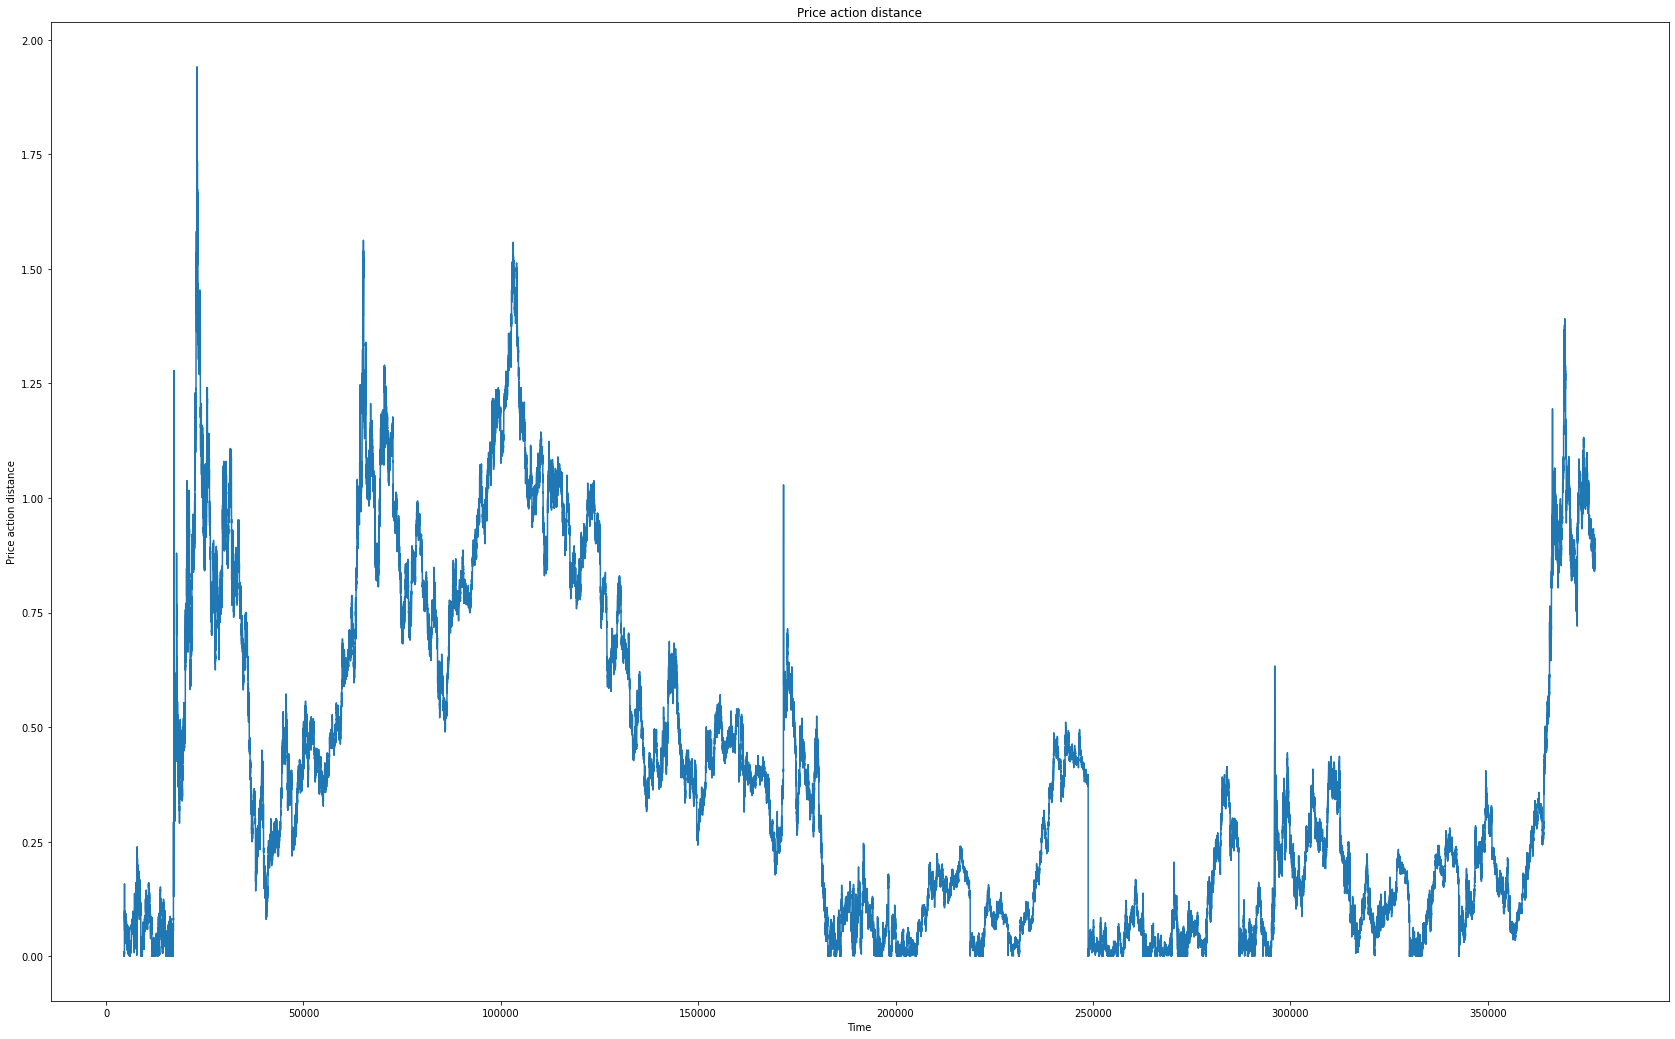

In [47]:
lpprices = sdf[sdf.long_pprice != 0.0]
pa_distance_long = (lpprices.long_pprice - lpprices.price).abs() / lpprices.price
print(f"Mean price action distance long {pa_distance_long.mean():.6f}")
pa_distance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.414483


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

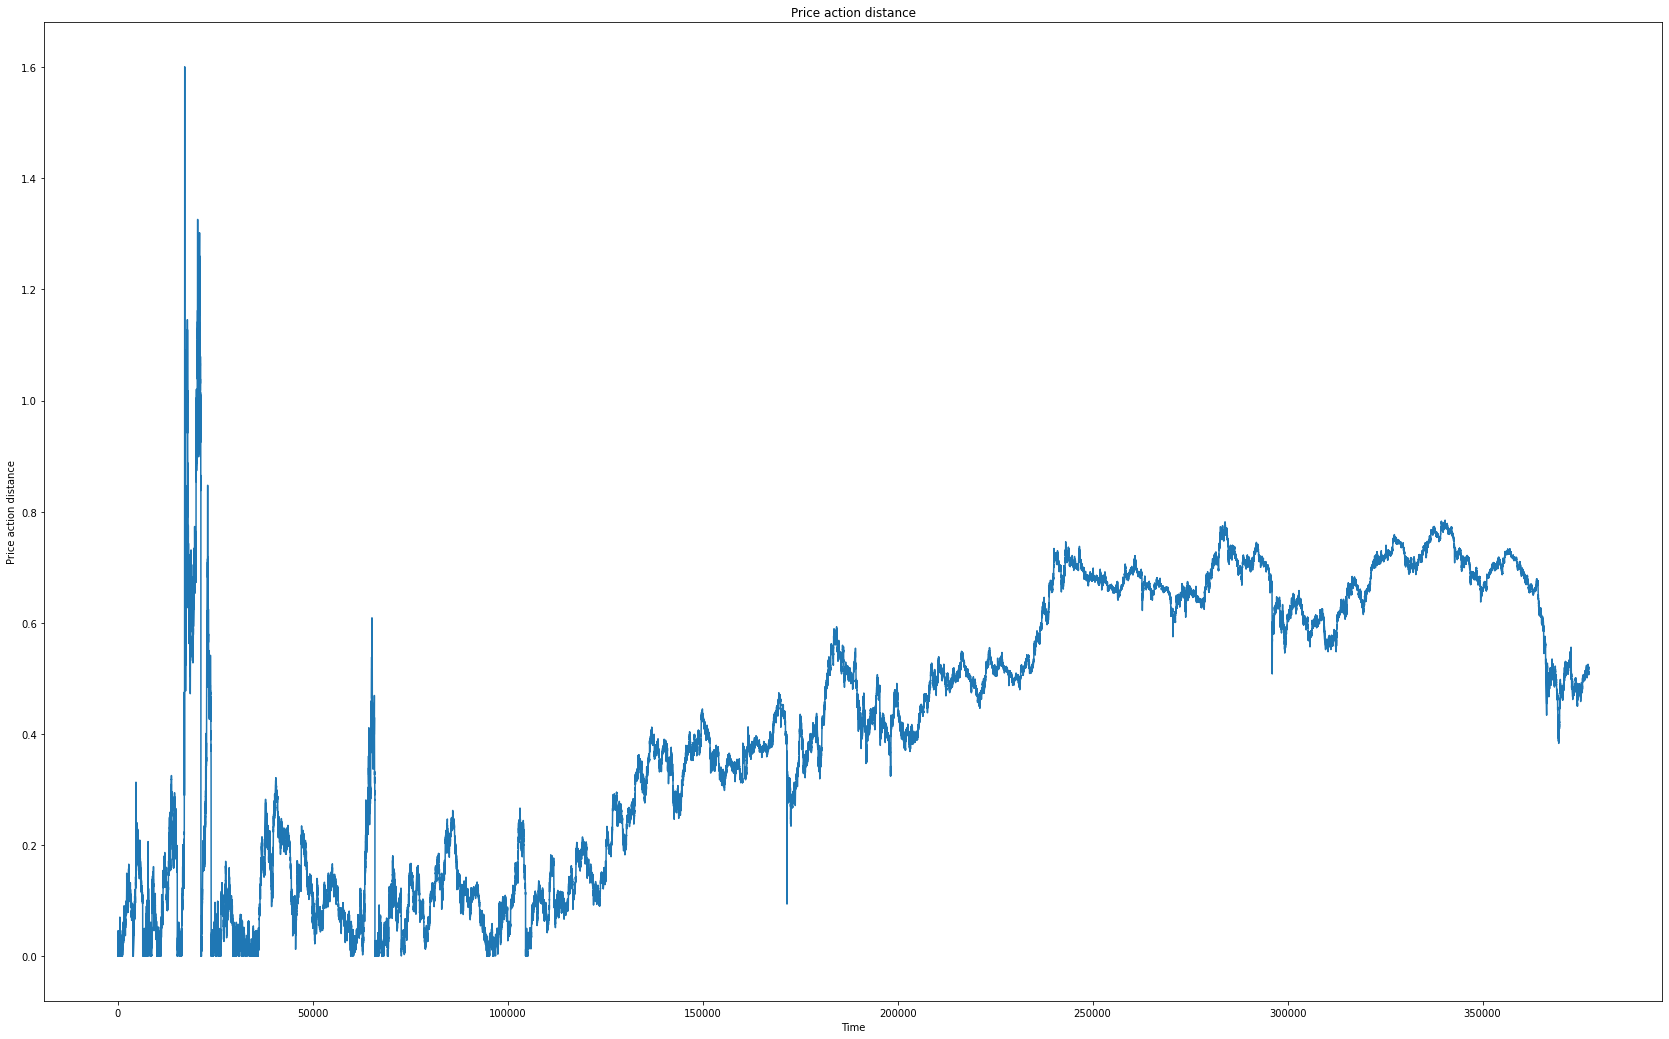

In [48]:
spprices = sdf[sdf.short_pprice != 0.0]
pa_distance_short = (spprices.short_pprice - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {pa_distance_short.mean():.6f}")
pa_distance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [9456.979757572499, 7769.356946894133, 6382.894847577279] n_days 274.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

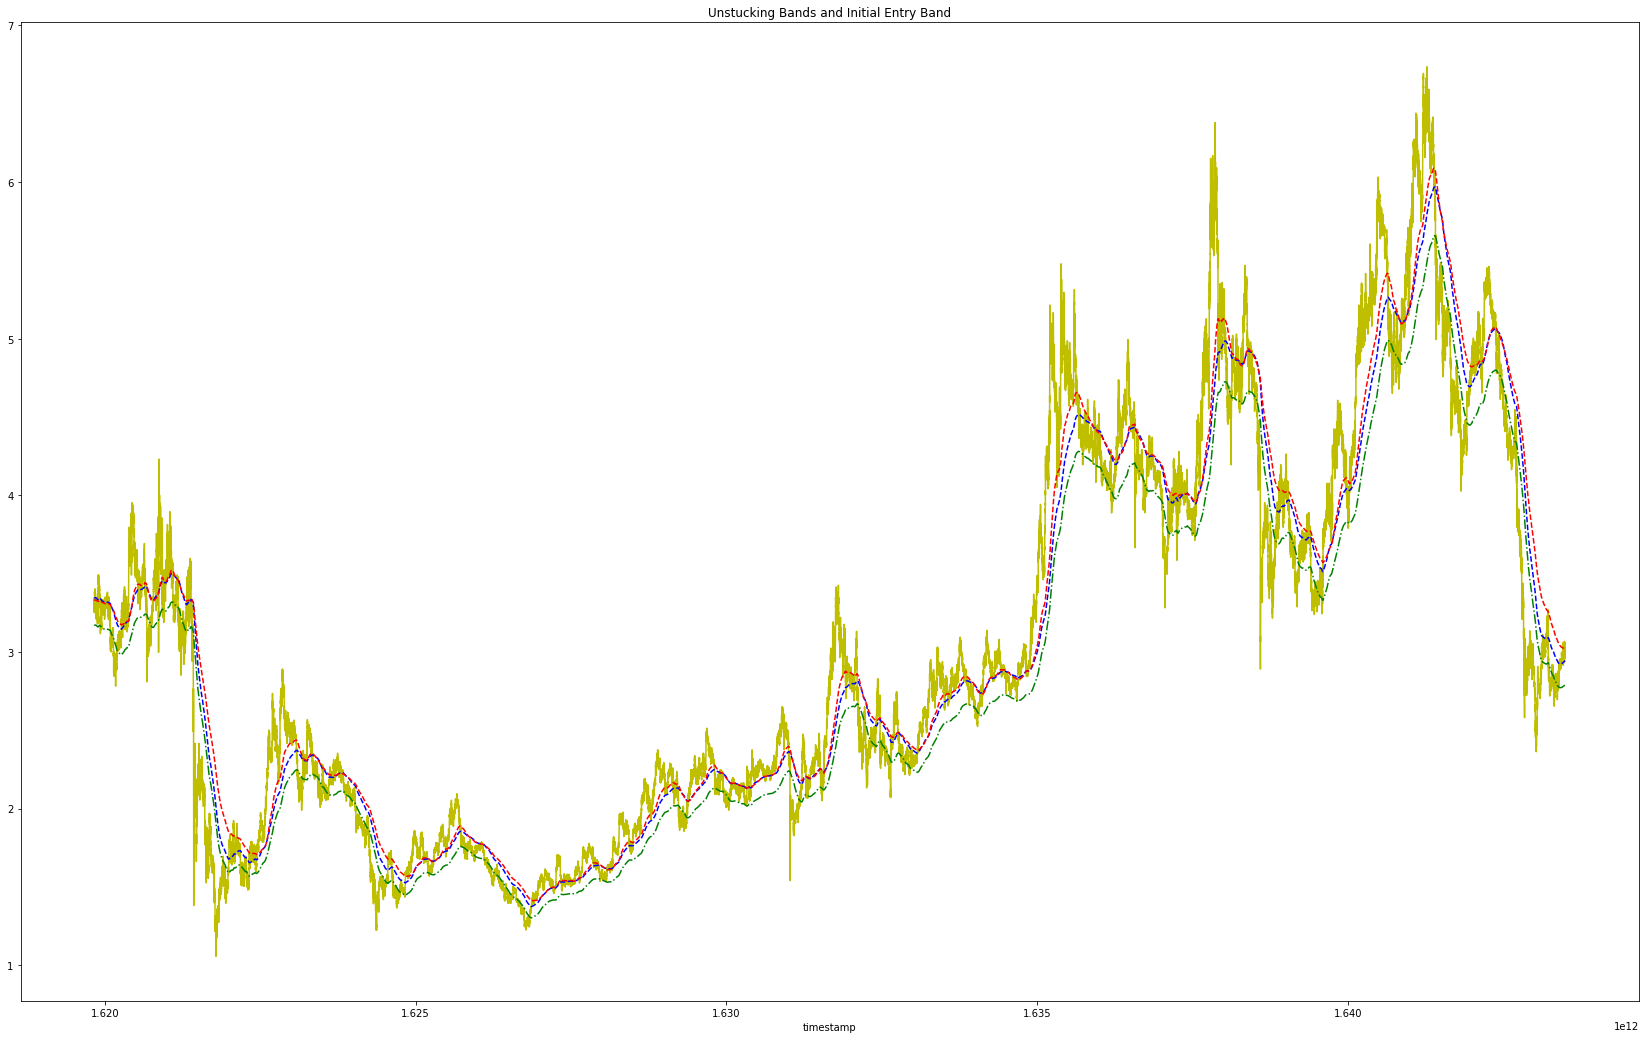

In [49]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_min"],
    (config_to_test["long"]["ema_span_min"] * config_to_test["long"]["ema_span_max"]) ** 0.5,
    config_to_test["long"]["ema_span_max"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
for i in range(3):
    # change to seconds
    spans[i] *= 60
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [1844.531106796071, 1182.0160621413836, 757.4618644339793] n_days 274.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

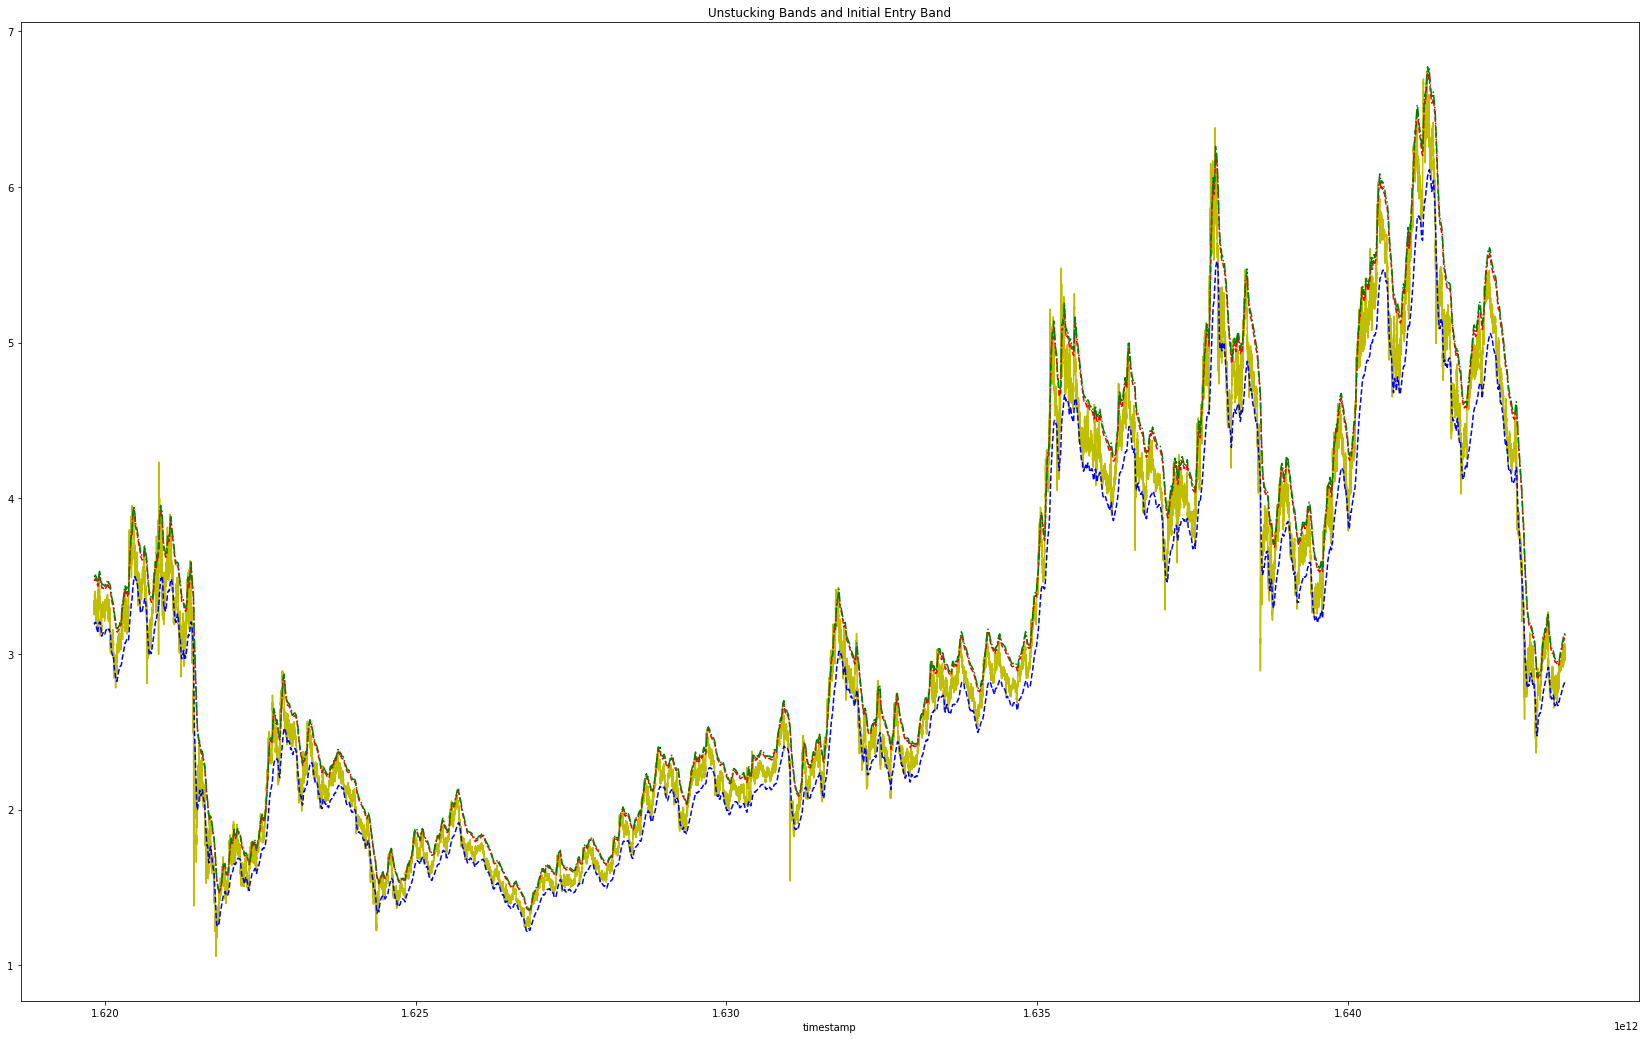

In [50]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_min"],
    (config_to_test["short"]["ema_span_min"] * config_to_test["short"]["ema_span_max"]) ** 0.5,
    config_to_test["short"]["ema_span_max"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
for i in range(3):
    # change to seconds
    spans[i] *= 60
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")

[[1.7      2.989    1.7      2.989    0.050813]]


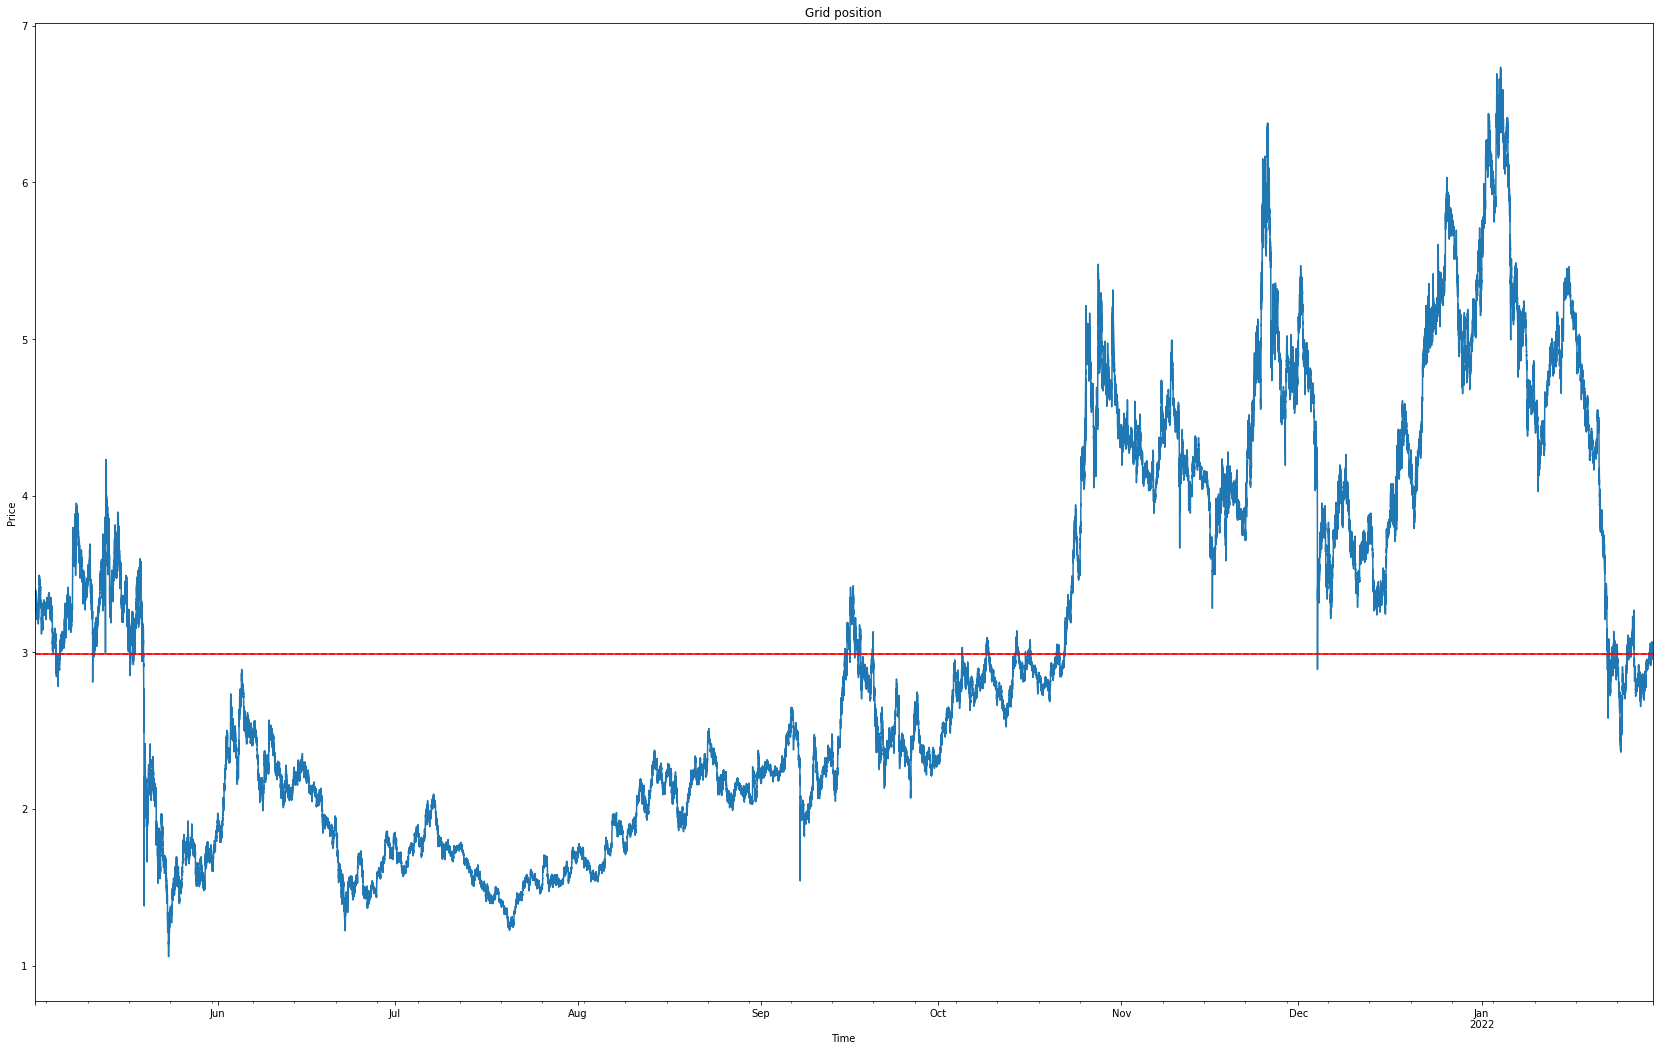

In [55]:
balance = config_to_test["starting_balance"]
highest_bid = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_long = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["long"]["grid_span"]
wallet_exposure_limit = config_to_test["long"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["long"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["long"]["initial_qty_pct"]
eprice_pprice_diff = config_to_test["long"]["eprice_pprice_diff"]
eprice_exp_base = config_to_test["long"]["eprice_exp_base"]
secondary_allocation = config_to_test["long"]["secondary_allocation"]
secondary_pprice_diff = config_to_test["long"]["secondary_pprice_diff"]



grid = calc_whole_long_entry_grid(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eprice_pprice_diff,
    secondary_allocation,
    secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base,
)
print(grid)

gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "qty": qtys, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    #plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [52]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nLong Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Long Grid Span = 0.00 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,1.7,2.989,1.7,2.989,0.050813,0.0,NaN,0.0


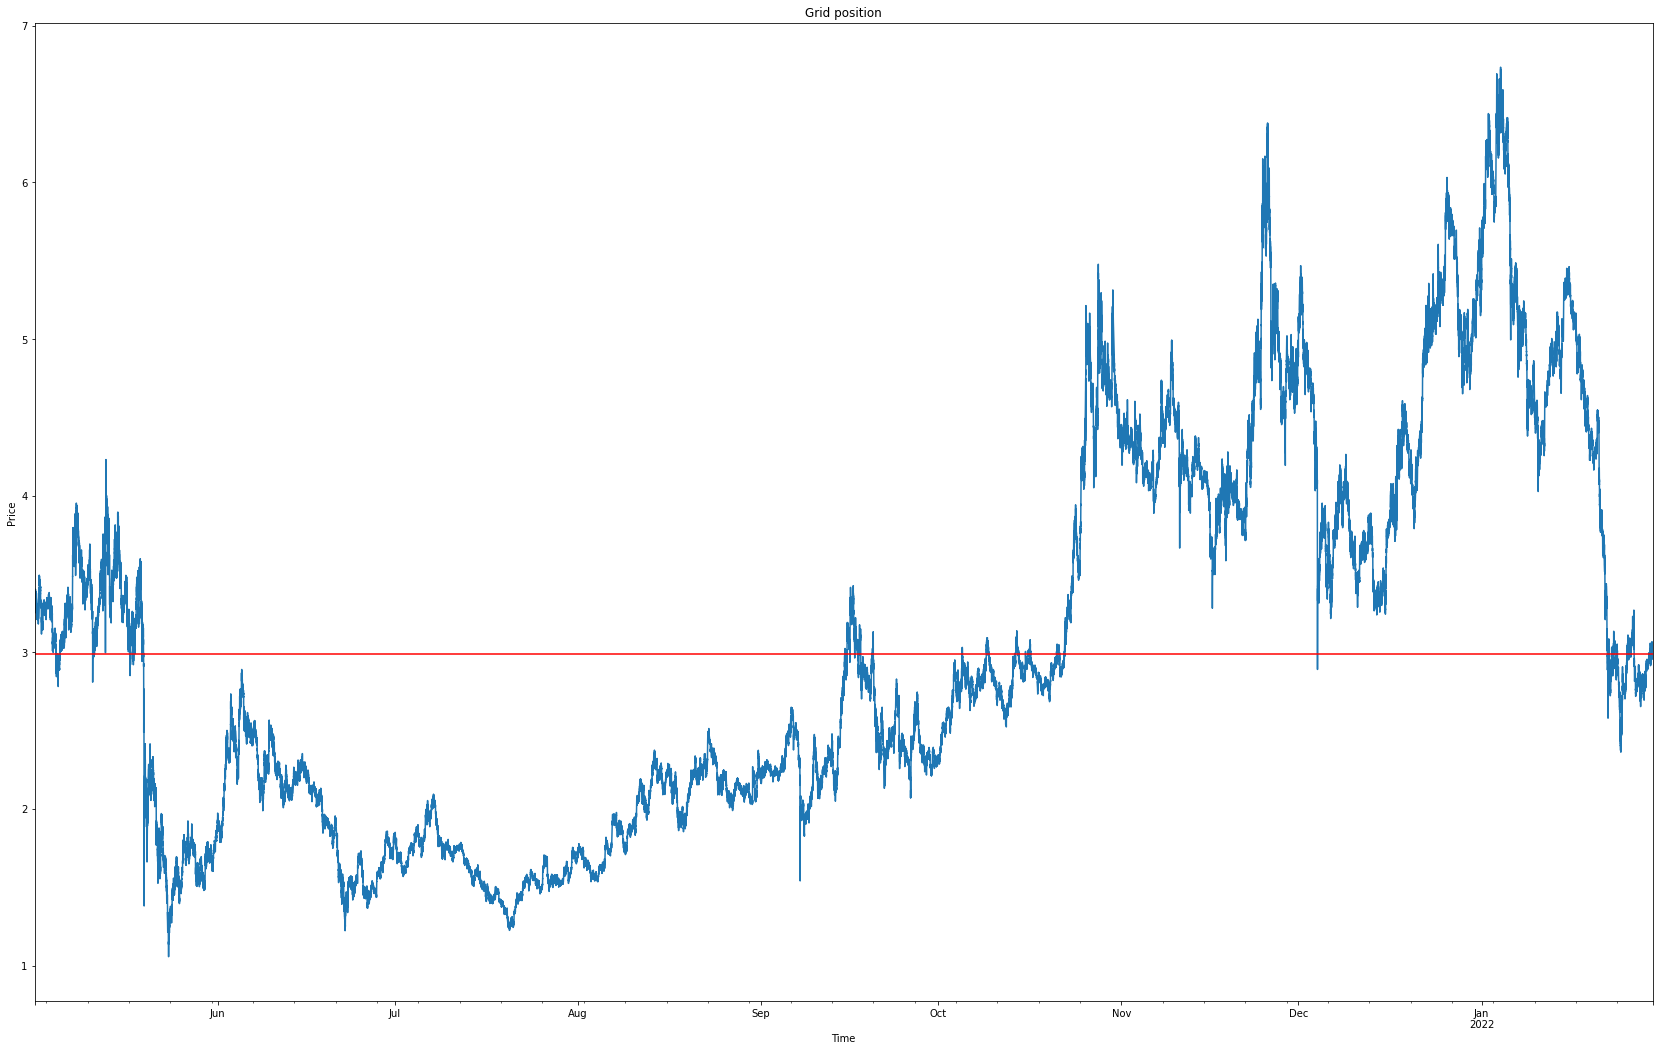

In [53]:
balance = config_to_test["starting_balance"]
lowest_ask = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_short = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["short"]["grid_span"]
wallet_exposure_limit = config_to_test["short"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["short"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["short"]["initial_qty_pct"]
eprice_pprice_diff = config_to_test["short"]["eprice_pprice_diff"]
eprice_exp_base = config_to_test["short"]["eprice_exp_base"]
secondary_allocation = config_to_test["short"]["secondary_allocation"]
secondary_pprice_diff = config_to_test["short"]["secondary_pprice_diff"]

grid = calc_whole_short_entry_grid(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eprice_pprice_diff,
    secondary_allocation,
    secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "qty": qtys, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [54]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nShort Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Short Grid Span = 0.00 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,-1.7,2.989,-1.7,2.989,0.050813,0.0,NaN,61.8125294118
